In [1]:
import matplotlib.pyplot as plt
import numpy as np, geopandas as gpd, pandas as pd, triangle
from descartes import PolygonPatch
from shapely.geometry import Point, MultiPolygon, MultiPoint, LineString
from shapely.ops import triangulate
from triangle import plot as tplot

## Create a simple shape

Pretend like these units are meters

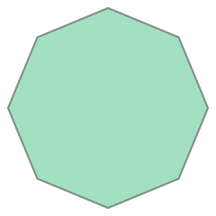

In [2]:
poly = Point((0, 0)).buffer(100).simplify(tolerance=10)
poly

Self-intersection at or near point -70.710678118654769 70.710678118654741


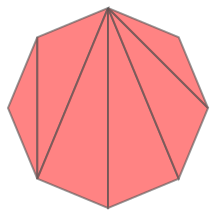

In [3]:
# perform a delaunay triangulation of this convex polygon
triangles = MultiPolygon(triangulate(poly))
triangles

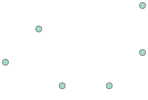

In [4]:
# get the centroids of each triangle
MultiPoint([tri.centroid for tri in triangles])

This works well with convex shapes, but not with concave shapes...

## Create a curvilinear concave shape

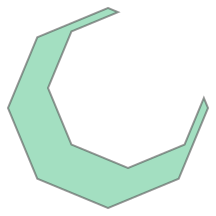

In [5]:
# make some concave shape
circle1 = Point((0, 0)).buffer(100).simplify(10)
circle2 = Point((20, 20)).buffer(80).simplify(10)
poly = circle1.difference(circle2)
poly

15


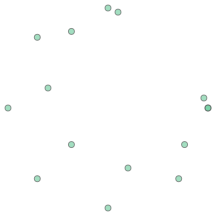

In [6]:
# see the vertices
print(len(list(poly.exterior.coords)))
vertices = MultiPoint([Point(x, y) for x, y in list(poly.exterior.coords)])
vertices

## Create delaunay triangulation with shapely

Self-intersection at or near point -100 -1.0106430996148606e-13


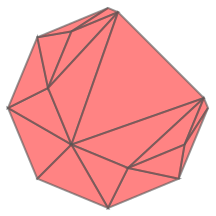

In [7]:
# perform a delaunay triangulation of the polygon
# problem is polygon is concave so you get a bad triangulation
triangles = MultiPolygon(triangulate(poly))
triangles

^^ you lose the concavity

## Create a constrained delaunay triangulation

In [8]:
# we need to perform a constrained delaunay triangulation to handle concave polygons
coords = list(poly.exterior.coords)
vertices = np.array(coords)
indices = list(range(len(coords)))
segments = np.array(list(zip(indices, indices[1:] + [indices[0]])))
poly_dict = {'vertices':vertices, 'segments':segments}

In [9]:
# flag p indicates this is a planar straight line graph, for constraining
# flag q20 indicates that triangles must have a minimum angle of 20 degrees
cndt = triangle.triangulate(tri=poly_dict, opts='pq20')

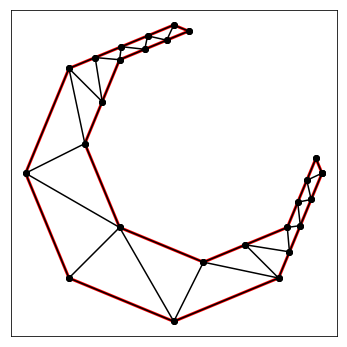

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
tplot.plot(ax, **cndt)
plt.show()

Now you can sample (centroids of) the above triangulated polygons, weighted by area (or not), to get representative points

## Or, sample with a grid of points

In [11]:
# what percent of the envelope does this poly take up?
# this could influence how fine-meshed we make the point grid
env = poly.envelope
poly.area / env.area

0.27884776310850234

In [12]:
# how far apart should the points be, in polygon's units
n = 15 #ie, 15 meters

In [13]:
# make a grid of points
left, bottom, right, top = env.bounds
x_points = np.linspace(left, right, int((right-left)/n))
y_points = np.linspace(bottom, top, int((top-bottom)/n))
xy_points = []
for x in x_points:
    for y in y_points:
        xy_points.append((x, y))

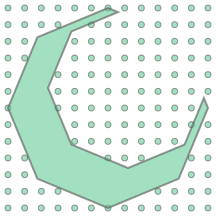

In [14]:
# give it a look...
points = MultiPoint([Point(x, y) for x, y in xy_points])
poly.union(points)

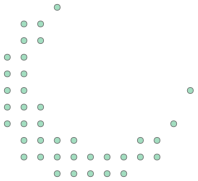

In [15]:
# now sample the points
points = gpd.GeoSeries([Point(x, y) for x, y in xy_points])
mask = points.intersects(poly)
points_sample = points[mask]
MultiPoint(points_sample.tolist())

## Find the nearest sampled point to each node in a set of nodes

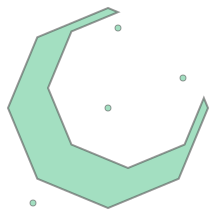

In [16]:
# make some "parcel" centroids and view them in relation to the polygon
centroid_points = MultiPoint([(0, 0), (75, 30), (10, 80), (-75, -95)])
centroids = gpd.GeoSeries(list(centroid_points))
poly.union(centroid_points)

In [17]:
# create an O-D dataframe for the distance matrix calculation
df_origin = pd.DataFrame()
df_origin['x'] = centroids.map(lambda coords: coords.x)
df_origin['y'] = centroids.map(lambda coords: coords.y)
df_origin = df_origin.assign(tmp_key=0)
df_origin = df_origin.reset_index()

df_dest = pd.DataFrame()
df_dest['x'] = points_sample.map(lambda coords: coords.x)
df_dest['y'] = points_sample.map(lambda coords: coords.y)
df_dest = df_dest.assign(tmp_key=0)
df_dest = df_dest.reset_index()

df_od = pd.merge(df_origin, df_dest, on='tmp_key', suffixes=('_from', '_to')).drop('tmp_key', axis=1)
df_od = df_od.set_index(['index_from', 'index_to'])

In [18]:
# calculate euclidean distance matrix, vectorized
# if these aren't projected (like meters), you can vectorize great-circle instead
x1 = df_od['x_from']
x2 = df_od['x_to']
y1 = df_od['y_from']
y2 = df_od['y_to']
dist_matrix = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
nearest = dist_matrix.unstack().idxmin(axis='columns')
nearest

index_from
0     44
1    162
2     63
3     28
dtype: int64

^^ the index is each "parcel" centroid's label and the value is the label of the nearest sampled point

## Show the result

"Parcel" centroids in cyan and nearest sampled points in black

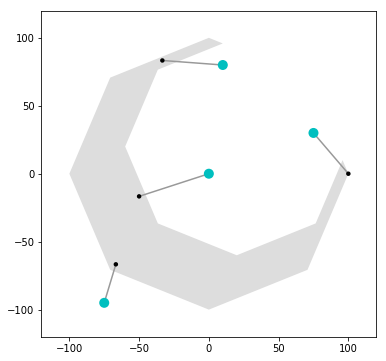

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
ax.add_patch(PolygonPatch(poly, fc='#dddddd', ec='none', zorder=0))

x = centroids.map(lambda coords: coords.x)
y = centroids.map(lambda coords: coords.y)
ax.scatter(x=x, y=y, facecolor='c', edgecolor='none', marker='o', s=100, zorder=2)

x = points_sample.loc[nearest].map(lambda coords: coords.x)
y = points_sample.loc[nearest].map(lambda coords: coords.y)
ax.scatter(x=x, y=y, facecolor='k', edgecolor='none', marker='o', s=20, zorder=2)

for label, value in nearest.iteritems():
    coords = df_od.loc[label, value]
    plt.plot([coords['x_from'], coords['x_to']], [coords['y_from'], coords['y_to']], c='#999999', zorder=1)

left, bottom, right, top = poly.bounds
ax.set_xlim(left * 1.2, right * 1.2)
ax.set_ylim(bottom * 1.2, top * 1.2)
plt.show()